In [1]:
import pandas as pd
import numpy as np
import scipy.stats
%matplotlib inline
import matplotlib.pyplot as plt

from pprint import pprint
pd.set_option('display.width', None)
pd.set_option('display.max_column',None)
pd.set_option('display.max_rows',None)

import warnings
warnings.filterwarnings('ignore')

# Functions

In [2]:
def KM_to_df(KM_object):
    
    # Process the summary as string
    
    summary_lines_list = str(KM_object.summary).split("\n")
    
    header = ["time", "events", "at_risk",  "estimate",  "std_error",  "95%_CI_lower",  "95%_CI_upper"]
    rows = summary_lines_list[6:]
    
    row_values = []
    
    for row in rows:
        
        elements = row.split(" ")
        tmp = []
        for element in elements:
            if element.isnumeric() or ("." in element):
                tmp.append(element)
                
        row_values.append(tmp)
        
    #Build df
    output_df = pd.DataFrame(row_values, columns=header)
                
    return output_df

def drop_by_index(X,indexes):
    """
    helper function to drop rows of dataframe and return new dataframe without those rows with indexes resetted
    """
    X = X.drop(indexes)
    X = X.reset_index().drop(columns="index")
    return(X)

def build_surv_obj(survival_type, years, df_dict):
    
    """
    This function builds the survival object to be processed by kaplan meier model to return kaplan meier df
    """
    
    survival_type = str(survival_type)
    years = str(years)
    
    survival_df = df_dict[years + "_years"][survival_type]
    
    Time_df = survival_df.loc[:,[survival_type + "_days"]]
    Time_df[survival_type + "_years"] = Time_df[survival_type + "_days"]/365.25
    Time_df["status"] = survival_df["status_" + survival_type]
    Time_df.head()

    return SurvivalData(time= (survival_type+ "_years"), status="status", data=Time_df)

def ComputeYears(df, Year_list):
    '''
    Create a list to contain df for different years of survival
    The df will filter those patient that has deceased or days of survival longer than the defined years.
    '''

    df_dict = {}

    for i in Year_list:
        tmp = {}
        for x in list(["DFS", "CSS", "OS"]):
            df['{}_{}_years'.format(x, i)] = np.where(
                                                      np.logical_or(df['death_age'] > 0,\
                                                      df['{}_days'.format(x)]/(365.25*i) >= i),\
                                                      True,False)
            tmp[x] = df[df['{}_{}_years'.format(x, i)] == True]
        df_dict['{}_years'.format(i)] = tmp
    return df_dict

def dataSetting(dropCol,FILE_FOLDER = "C:\\SMU_v2\\"):
    '''
    function to read the pkl from from datasource
        1. Remove dx_date that is NULL.
        2. Drop all rows where crucial fields for X_features are NULL.
        3. Convert Date columns into datetime format
        4. Derive OS, CSS, DFS days based on dx_date
        5. Create status column to indicate if the patient is dead or alive base on if death_age exists
    '''
    df = pd.read_pickle(FILE_FOLDER + "clinical_output.pkl").reset_index().drop(columns="index")
    to_drop = df[df['dx_date']=="NA"].index
    df = drop_by_index(df,to_drop)

    df.drop(columns=dropCol,inplace = True)

    # drop all rows where dates are null
    df.dropna(axis=0,\
                    subset=['Date_for_DFS','Date_for_OS','Date_for_CSS','dx_date','size_precise', 'nodespos'],\
                    inplace=True)

    # convert all datetime in dataframe into dateime format for processing
    df["Date_for_DFS"] = pd.to_datetime(df["Date_for_DFS"])
    df["Date_for_OS"] = pd.to_datetime(df["Date_for_OS"])
    df["Date_for_CSS"] = pd.to_datetime(df["Date_for_CSS"])
    df["dx_date"] = pd.to_datetime(df["dx_date"])
    df['last_seen']= pd.to_datetime(df["dx_date"])

    # calculate in days
    df["DFS_days"] = (df["Date_for_DFS"] - df['dx_date'] )/np.timedelta64(1, 'D')
    df["OS_days"] = (df["Date_for_OS"] - df['dx_date'] )/np.timedelta64(1, 'D')
    df["CSS_days"] = (df["Date_for_CSS"] - df['dx_date'] )/np.timedelta64(1, 'D')

    # alive or dead
    df['status_OS'] = np.where(df['Count_as_OS'] != "N", True, False)
    df['status_DFS'] = np.where(df['Count_as_DFS'] != "N", True, False)
    df['status_CSS'] = np.where(df['Count_as_CSS'] != "N", True, False)
    
    return df

def layeredData(df, group_dict,y_features, YEAR, STYPE):
    
    '''
        this function generates the dataframe required for specific groups we hope to analyze
        there are total 3 different groups but group 3 consist of multiple subgroups which leads a total of 5
        dataframe.
        Group 1: patient with stage 4 cancer
        Group 2: patient which unknown records or at initial diagnosis stage
        Group 3: make up of patient that does not belong to the groups above
    '''
    model_data_dict = {}
    TO_USE = df['{}_years'.format(YEAR)][STYPE]
    
    print("Overall initial size: {} \n".format(TO_USE.shape[0]))
        
    for key,value in group_dict.items():
        TO_USE_COPY = TO_USE.copy()

        tmp = {}
        
        waves = value['wave']
    
        if key != "group 3":
            # for group 1 and group 2 select rows that contains either stage 4/non invasive in Stage
            TO_USE_COPY = TO_USE_COPY.loc[TO_USE_COPY['Stage'] == group_dict[key]['stage'][0]]
        else:
            # for group 3 do not select rows that contains either stage 4 or non invasive in c_Staging or p_Staging
            stage = np.logical_and(TO_USE_COPY['Stage'] != group_dict[key]['stage'][0],\
                                    TO_USE_COPY['Stage'] != group_dict[key]['stage'][1])
            
            TO_USE_COPY = TO_USE_COPY.loc[stage]
            
        print("{} data size: {}".format(key,len(TO_USE_COPY)))
        
        for wave in waves:
            TO_USE_COPY2 = TO_USE_COPY.copy()
            TO_USE_COPY2 = TO_USE_COPY2[waves[wave] + y_features]
            
            len_before = len(TO_USE_COPY2)
            print("\t{} data size before dropping nan: {}".format(wave,len_before))
            
            TO_USE_COPY2.dropna(axis=0,subset=waves[wave]+ y_features, inplace=True)
            TO_USE_COPY2.reset_index(drop=True)

            len_after = len(TO_USE_COPY2)
            print("\t\t after dropping nan: {}".format(len_after))
            
            for i in waves[wave]:
                if not (i in ['nodespos','Age_@_Dx','size_precise']):
                    TO_USE_COPY2.loc[:,i] = TO_USE_COPY2[i].astype("category")
                else:
                    TO_USE_COPY2.loc[:,i] = TO_USE_COPY2[i].astype("float32")
            
            X, Y = settingXY(TO_USE_COPY2, waves[wave], y_features,name= "{}_{}".format(key,wave))   

            tmp[wave] = {
                            "X": X,\
                            "Y":Y      
                        }    
    
        model_data_dict[key] = tmp
    return model_data_dict

### Data Processing

In [3]:
listToDrop = ['NRIC','dob','Has Bills?','Side','Hospital','KKH','NCCS','SGH']

clinical = dataSetting(listToDrop)

year_list = list([1,5,10])
df_dict = ComputeYears(clinical,year_list)
y_features = []

YEAR = 1
STYPE = "OS"

group_dict = { 
                "group 1": {
                             "stage": ['stage 4'],\
                             'wave': {
                                         "layer 1": ['Age_@_Dx', 'diff', 'ER', 'PR','Her2','Stage'],\
                                         "layer 2": ['Age_@_Dx', 'diff', 'ER', 'PR','Her2',\
                                                     'T (no subgroup)', 'N (no subgroup)'],\
                                         "layer 3": ['Age_@_Dx', 'diff', 'ER', 'PR','Her2', 'T', 'N'],\
                                         "layer 4": ['Age_@_Dx', 'diff', 'ER', 'PR','Her2', 'size_precise', 'nodespos']
                                     }
                           },\
                "group 2": {
                             'stage': ['dcis/lcis non-invasive'],\
                             'wave': {
                                         "layer 1": ['Age_@_Dx', 'diff', 'ER', 'PR','Her2','Size'],\
                                         "layer 2": ['Age_@_Dx', 'diff', 'ER', 'PR','Her2','size_precise']
                                     }
                           },\
                "group 3": {
                             "stage": ['stage 4','dcis/lcis non-invasive'],\
                             'wave': {
                                         "layer 1": ['Age_@_Dx', 'diff', 'ER', 'PR','Her2','Stage'],\
                                         "layer 2": ['Age_@_Dx', 'diff', 'ER', 'PR','Her2',\
                                                     'T (no subgroup)', 'N (no subgroup)', 'M (no subgroup)'],\
                                         "layer 3": ['Age_@_Dx', 'diff', 'ER', 'PR','Her2', 'T', 'N', 'M'],\
                                         "layer 4": ['Age_@_Dx', 'diff', 'ER', 'PR','Her2', 'size_precise',\
                                                     'nodespos','M']
                                     }
                           },
                }

# Display shape of data after filtering
# for i in df_dict:
#     for s_type in df_dict[i]:
#         print("Year: {}, survival category: {}, size: {}".format(i,s_type,df_dict[i][s_type].shape))
    
model_data_dict = layeredData(df_dict, group_dict,y_features,YEAR, STYPE)

Overall initial size: 15118 

group 1 data size: 457
	layer 1 data size before dropping nan: 457
		 after dropping nan: 457


NameError: name 'settingXY' is not defined

In [ ]:
df_dict["10_years"]["OS"].head()

### Kaplan Meier Analysis

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", palette="colorblind", color_codes=True)

from survive import datasets
from survive import SurvivalData
from survive import KaplanMeier, Breslow, NelsonAalen

Overall Survival Modeling

,time,events,at_risk,estimate,std_error,95%_CI_lower,95%_CI_upper
0,0.030116,1,2785,0.999641,0.000359,0.997454,0.999949
1,0.038330,1,2784,0.999282,0.000508,0.997132,0.999820
2,0.041068,1,2783,0.998923,0.000622,0.996664,0.999652
3,0.057495,1,2782,0.998564,0.000718,0.996178,0.999461
4,0.062971,1,2781,0.998205,0.000802,0.995692,0.999252
5,0.065708,1,2780,0.997846,0.000879,0.995211,0.999032
6,0.068446,1,2779,0.997487,0.000949,0.994735,0.998801
7,0.123203,1,2778,0.997127,0.001014,0.994264,0.998562
8,0.150582,1,2777,0.996768,0.001075,0.993798,0.998317
9,0.153320,1,2776,0.996409,0.001133,0.993337,0.998066


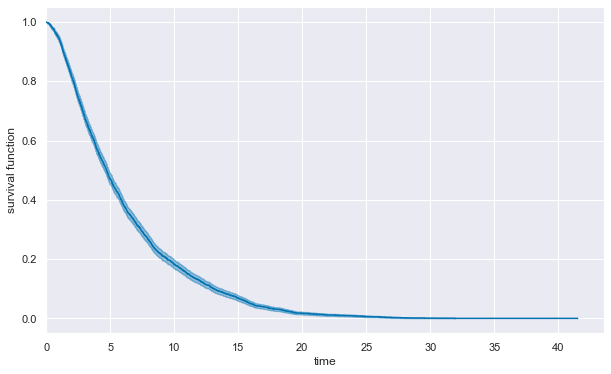

In [64]:
#Build Input DF
surv = build_surv_obj(survival_type="OS", years=10, df_dict=df_dict)
OS_km = KaplanMeier()
OS_km.fit(surv)
KM_to_df(OS_km)

#Plot Curve
plt.figure(figsize=(10, 6))
OS_km.plot()
plt.show()
plt.close()

Disease Free Survival

Kaplan-Meier estimator

 total  events  censored
  2615    2615         0

      time  events  at risk  estimate  std. error  95% c.i. lower  95% c.i. upper
  0.002738       2     2615  0.999235    0.000541        0.996945        0.999809
  0.008214       1     2613  0.998853    0.000662        0.996447        0.999630
  0.013689       1     2612  0.998470    0.000764        0.995930        0.999426
  0.024641       1     2611  0.998088    0.000854        0.995412        0.999204
  0.027379       2     2610  0.997323    0.001010        0.994393        0.998723
  0.032854       1     2608  0.996941    0.001080        0.993892        0.998469
  0.035592       1     2607  0.996558    0.001145        0.993396        0.998208
  0.038330       2     2606  0.995793    0.001266        0.992417        0.997668
  0.043806       2     2604  0.995029    0.001375        0.991454        0.997110
  0.046543       1     2602  0.994646    0.001427        0.990977        0.996826
  0.054757       1     

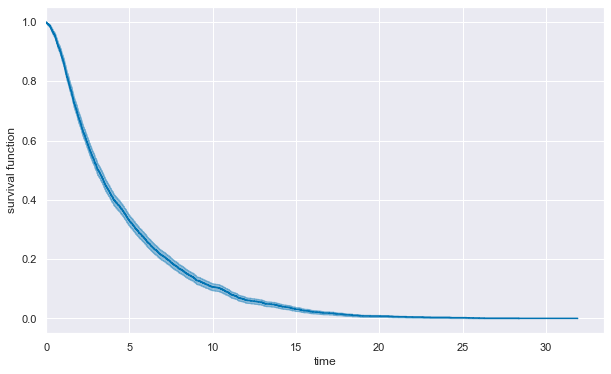

group,0
time,
0.002738,0.999235
1.000000,0.872275
2.000000,0.669598
3.000000,0.517400
4.000000,0.407648
5.000000,0.329637
6.000000,0.264245
7.000000,0.211472
8.000000,0.167495


In [40]:
#Build Input DF
surv = build_surv_obj(survival_type="DFS",years=10, df_dict=df_dict)
DFS_km = KaplanMeier()
DFS_km.fit(surv)
print(DFS_km.summary)
print(DFS_km)

#Plot curve
plt.figure(figsize=(10, 6))
DFS_km.plot()
plt.show()
plt.close()

#Estimate is basically reading off the curve at the respective time
estimate = DFS_km.predict([0.002738,1,2,3,4,5,6,7,8,9,10])
display(estimate)

Cancer Specific Survival

In [ ]:
#Build Input DF
surv = build_surv_obj(survival_type="CSS", years=10, df_dict=df_dict)
CSS_km = KaplanMeier()
CSS_km.fit(surv)
# print(CSS_km.summary)
print(CSS_km)

#Plot curve
plt.figure(figsize=(10, 6))
CSS_km.plot()
plt.show()
plt.close()